In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [33]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)

        out_ft = torch.zeros_like(x_ft, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


In [34]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(1 + 2, self.width)  # Input channels adjusted to 1 (image) + 2 (grid)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)  # Concatenate along channel dimension
        x = self.fc0(x.permute(0, 2, 3, 1))  # Reshape to match linear layer expectations

        x = x.permute(0, 3, 1, 2)  # Reshape back to NCHW format
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = nn.GELU()(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = nn.GELU()(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = nn.GELU()(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)  # Reshape for final linear layers
        x = self.fc1(x)
        x = nn.GELU()(x)
        x = self.fc2(x)
        x = x.permute(0, 3, 1, 2)  # Reshape back to NCHW
        return x

    def get_grid(self, shape, device):
        batchsize, _, size_x, size_y = shape
        gridx = torch.linspace(0, 1, size_x, device=device).reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.linspace(0, 1, size_y, device=device).reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1)

In [75]:
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert('L')
    return transform(image).unsqueeze(0) 

In [76]:
def upscale_image(model, blurry_image, optimizer, criterion, epochs):
    model.train()
    blurry_image = blurry_image.to(device)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(blurry_image)
        loss = criterion(output, blurry_image)  # Autoencoder-like training
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    return output.detach()

In [124]:
modes = 12
width = 20
model = FNO2d(modes, modes, width).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.MSELoss()

In [119]:
lres_img=load_image('img-01.jpg').to(device)

In [120]:
lres_img.shape

torch.Size([1, 1, 512, 512])

In [125]:
hres_img=upscale_image(model, lres_img, optimizer, criterion, 100)

Epoch 1, Loss: 0.15400338172912598
Epoch 2, Loss: 0.14351299405097961
Epoch 3, Loss: 0.13394871354103088
Epoch 4, Loss: 0.12525811791419983
Epoch 5, Loss: 0.11740759760141373
Epoch 6, Loss: 0.11037327349185944
Epoch 7, Loss: 0.10413754731416702
Epoch 8, Loss: 0.0986907035112381
Epoch 9, Loss: 0.09402875602245331
Epoch 10, Loss: 0.09014897048473358
Epoch 11, Loss: 0.08704453706741333
Epoch 12, Loss: 0.08469817042350769
Epoch 13, Loss: 0.08307329565286636
Epoch 14, Loss: 0.08210226148366928
Epoch 15, Loss: 0.08167249709367752
Epoch 16, Loss: 0.08161437511444092
Epoch 17, Loss: 0.08170230686664581
Epoch 18, Loss: 0.08168412744998932
Epoch 19, Loss: 0.0813329815864563
Epoch 20, Loss: 0.08049024641513824
Epoch 21, Loss: 0.07907813787460327
Epoch 22, Loss: 0.07708653807640076
Epoch 23, Loss: 0.07454763352870941
Epoch 24, Loss: 0.07150974869728088
Epoch 25, Loss: 0.06801627576351166
Epoch 26, Loss: 0.06409267336130142
Epoch 27, Loss: 0.05974210053682327
Epoch 28, Loss: 0.05494963750243187
Epo

In [126]:
output_image = hres_img.squeeze(0).squeeze(0).cpu().detach().numpy()
output_image = (output_image * 255).astype(np.uint8)
output_image.shape

(512, 512)

In [127]:
orgnl_img=lres_img.squeeze(0).squeeze(0).cpu().detach().numpy()
orgnl_img = (orgnl_img * 255).astype(np.uint8)
orgnl_img.shape

(512, 512)

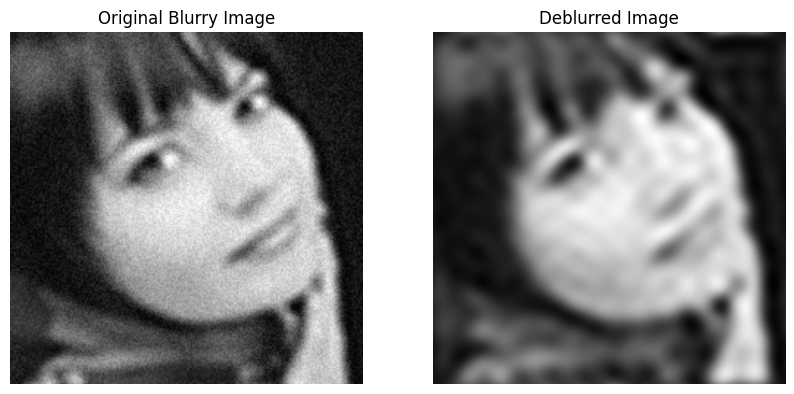

In [128]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Blurry Image")
plt.imshow(orgnl_img, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Deblurred Image")
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.show()